In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import glob
import os
import pandas as pd
from PIL import Image
from torchvision.models import efficientnet_b0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
collab = False
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCHS = 10000


if collab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/MyDrive/ai_data/rov/data/cube'
    EPOCHS = 10000
    BATCH_SIZE = 32
else:
    ROOT_DIR = './data'

torch.Size([16, 3, 256, 256])


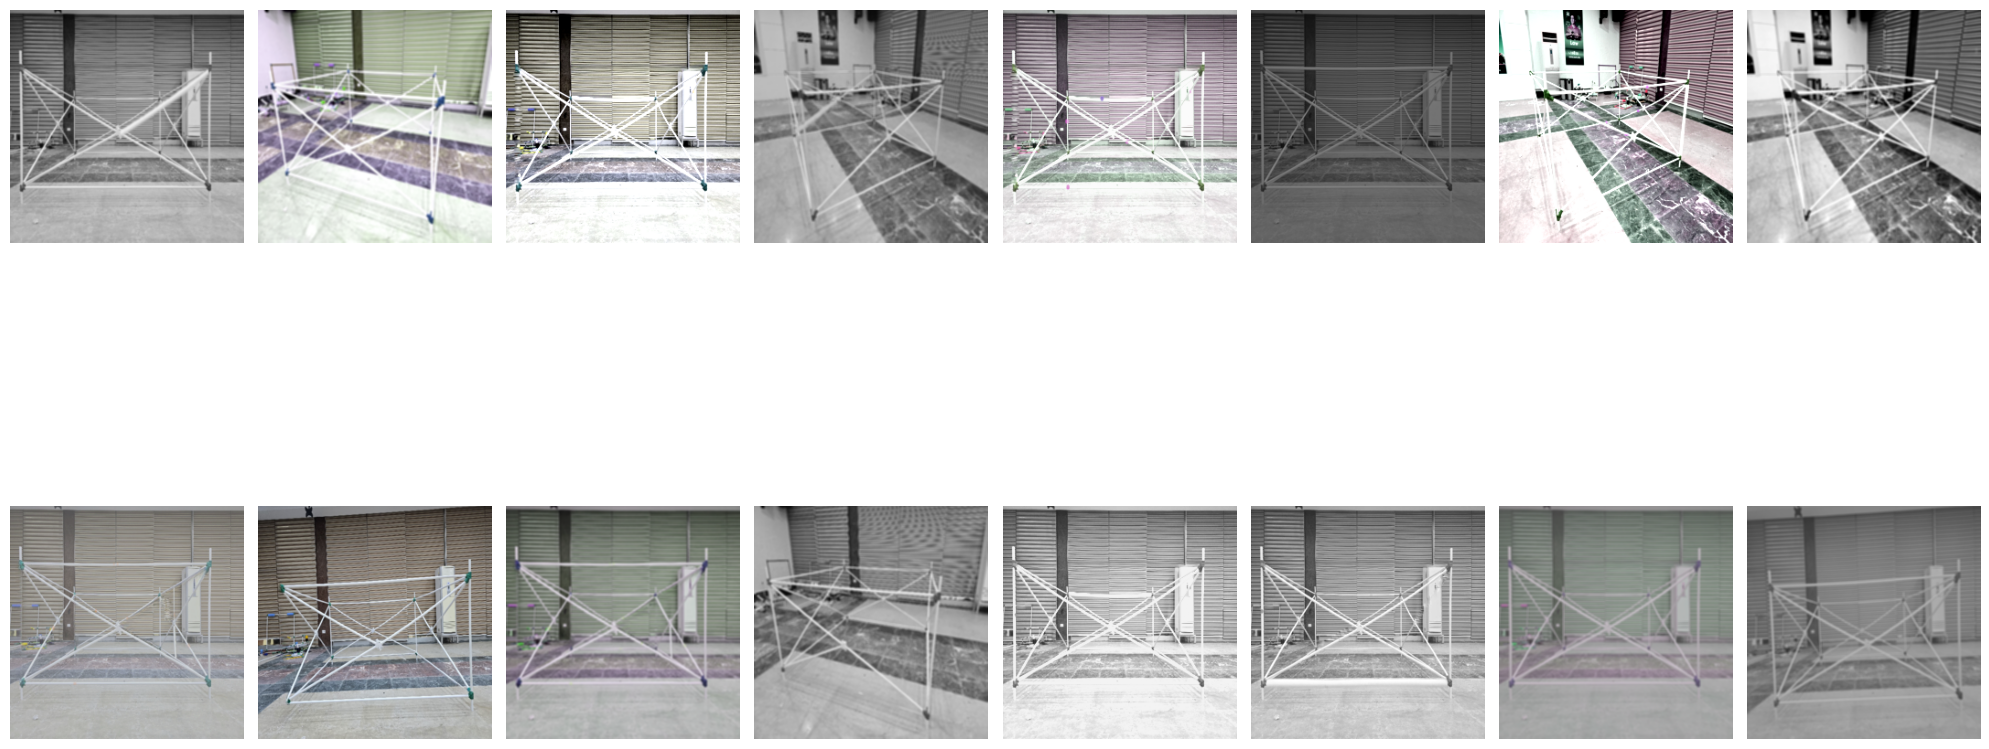

In [4]:
class CubeDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform

        # Only real data directories
        real_dir = os.path.join(ROOT_DIR, "real")
        annots_dir = os.path.join(ROOT_DIR, "annots")

        # Load annotation dataframes for real images
        real_missing_df = pd.read_csv(
            os.path.join(annots_dir, "real_missing.csv"), dtype=str
        ).set_index("name")
        real_oxide_df = pd.read_csv(
            os.path.join(annots_dir, "real_oxide.csv"), dtype=str
        ).set_index("name")
        real_odd_df = pd.read_csv(
            os.path.join(annots_dir, "real_odd_size.csv"), dtype=str
        ).set_index("name")

        # Containers
        self.data = []
        self.missing_labels = []
        self.oxide_labels = []
        self.odd_size_labels = []

        # Iterate over real images
        for ext in ("*.jpeg", "*.jpg", "*.png"):
            for img_path in glob.glob(os.path.join(real_dir, ext)):
                name = os.path.basename(img_path)
                # Skip if any annotation missing
                if (
                    name not in real_missing_df.index
                    or name not in real_oxide_df.index
                    or name not in real_odd_df.index
                ):
                    continue

                missing_ann = real_missing_df.loc[name]
                oxide_ann = real_oxide_df.loc[name]
                odd_ann = real_odd_df.loc[name]

                # Convert per-face strings to lists of ints
                missing_face = [
                    [int(c) for c in missing_ann[face].strip()]
                    for face in ("front", "left", "back", "right")
                ]
                oxide_face = [
                    [int(c) for c in oxide_ann[face].strip()]
                    for face in ("front", "left", "back", "right")
                ]
                odd_face = [
                    [int(c) for c in odd_ann[face].strip()]
                    for face in ("front", "left", "back", "right")
                ]

                self.data.append(img_path)
                self.missing_labels.append(missing_face)
                self.oxide_labels.append(oxide_face)
                self.odd_size_labels.append(odd_face)

        # Ensure consistency
        assert (
            len(self.data)
            == len(self.missing_labels)
            == len(self.oxide_labels)
            == len(self.odd_size_labels)
        ), "Data/Labels length mismatch"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        missing_tensor = torch.tensor(self.missing_labels[idx], dtype=torch.float32)
        oxide_tensor = torch.tensor(self.oxide_labels[idx], dtype=torch.float32)
        odd_tensor = torch.tensor(self.odd_size_labels[idx], dtype=torch.float32)
        return img, missing_tensor, oxide_tensor, odd_tensor

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.3)], p=0.8),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,3))], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CubeDataset(transform=train_transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Visualization example (unchanged)
img, missing, oxided, odd = next(iter(train_loader))
print(img.shape)
plt.figure(figsize=(20, 20))
for i in range(len(img)):
    plt.subplot(4, 8, i + 1)
    img_show = img[i].permute(1, 2, 0)
    img_show = img_show * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img_show = torch.clamp(img_show, 0, 1)
    plt.imshow(img_show)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
class PipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = efficientnet_b0(weights='DEFAULT').features
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[-1].parameters():
            param.requires_grad = True
            
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Linear(1280, 320),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.missing_head = nn.Linear(320, 4*10)
        self.oxide_head = nn.Linear(320, 4*10)
        self.odd_head = nn.Linear(320, 4*10)

    def forward(self, x):
        x = self.pool(self.backbone(x)).flatten(1)
        x = self.head(x)
        return {
            "missing": self.missing_head(x).view(-1, 4, 10),
            "oxide": self.oxide_head(x).view(-1, 4, 10),
            "odd": self.odd_head(x).view(-1, 4, 10)
        }

model = PipeNetwork().to(device)
model.load_state_dict(torch.load(f'{ROOT_DIR}/checkpoints/pipe_detector.pth'))
model.to(device)
# model(torch.randn(16, 3, 256, 256))
summary(model, torch.randn((16, 3, 256, 256)))
print()

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1280, 8, 8]          --
|    └─Conv2dNormActivation: 2-1              [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                       [-1, 32, 128, 128]        (864)
|    |    └─BatchNorm2d: 3-2                  [-1, 32, 128, 128]        (64)
|    |    └─SiLU: 3-3                         [-1, 32, 128, 128]        --
|    └─Sequential: 2-2                        [-1, 16, 128, 128]        --
|    |    └─MBConv: 3-4                       [-1, 16, 128, 128]        (1,448)
|    └─Sequential: 2-3                        [-1, 24, 64, 64]          --
|    |    └─MBConv: 3-5                       [-1, 24, 64, 64]          (6,004)
|    |    └─MBConv: 3-6                       [-1, 24, 64, 64]          (10,710)
|    └─Sequential: 2-4                        [-1, 40, 32, 32]          --
|    |    └─MBConv: 3-7                       [-1, 40, 32, 32]          (1

In [11]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='none')

for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0
    for imgs, missing_label, oxide_label, odd_label in train_loader:
        imgs = imgs.to(device)
        missing_label = missing_label.to(device)
        oxide_label = oxide_label.to(device)
        odd_label = odd_label.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)  # [B,4,10]

        loss_missing = criterion(outputs['missing'], missing_label).mean()
        loss_oxide = criterion(outputs['oxide'], oxide_label).mean()

        loss_odd = criterion(outputs['odd'], odd_label)
        weighted_mask = torch.where(odd_label  == 1, 10, 1.0)
        loss_odd = (weighted_mask * loss_odd).mean()

        loss = loss_missing + loss_oxide + loss_odd
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {epoch_loss:.4f}")
    model.to(torch.device('cpu'))
    torch.save(model.state_dict(), f'{ROOT_DIR}/checkpoints/pipe_detector.pth')
    model.to(device)

Epoch 1/10000 - Loss: 0.2337
Epoch 2/10000 - Loss: 0.2890
Epoch 3/10000 - Loss: 0.1793
Epoch 4/10000 - Loss: 0.2034
Epoch 5/10000 - Loss: 0.2305
Epoch 6/10000 - Loss: 0.1675
Epoch 7/10000 - Loss: 0.1265
Epoch 8/10000 - Loss: 0.2267
Epoch 9/10000 - Loss: 0.2453
Epoch 10/10000 - Loss: 0.1225
Epoch 11/10000 - Loss: 0.1419
Epoch 12/10000 - Loss: 0.1475
Epoch 13/10000 - Loss: 0.1447
Epoch 14/10000 - Loss: 0.1804
Epoch 15/10000 - Loss: 0.1347
Epoch 16/10000 - Loss: 0.1305
Epoch 17/10000 - Loss: 0.1296
Epoch 18/10000 - Loss: 0.1037
Epoch 19/10000 - Loss: 0.1241
Epoch 20/10000 - Loss: 0.1663
Epoch 21/10000 - Loss: 0.1108
Epoch 22/10000 - Loss: 0.0876
Epoch 23/10000 - Loss: 0.1764
Epoch 24/10000 - Loss: 0.1264
Epoch 25/10000 - Loss: 0.1117
Epoch 26/10000 - Loss: 0.1175
Epoch 27/10000 - Loss: 0.1411
Epoch 28/10000 - Loss: 0.1077
Epoch 29/10000 - Loss: 0.1133
Epoch 30/10000 - Loss: 0.0940
Epoch 31/10000 - Loss: 0.0987
Epoch 32/10000 - Loss: 0.0925
Epoch 33/10000 - Loss: 0.1383
Epoch 34/10000 - Lo

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f661ed440e0>
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 133, in __del__
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch 158/10000 - Loss: 0.0718
Epoch 159/10000 - Loss: 0.0551
Epoch 160/10000 - Loss: 0.0868
Epoch 161/10000 - Loss: 0.0589
Epoch 162/10000 - Loss: 0.0685
Epoch 163/10000 - Loss: 0.0941
Epoch 164/10000 - Loss: 0.0655
Epoch 165/10000 - Loss: 0.0879
Epoch 166/10000 - Loss: 0.1517
Epoch 167/10000 - Loss: 0.0957
Epoch 168/10000 - Loss: 0.0659
Epoch 169/10000 - Loss: 0.0822
Epoch 170/10000 - Loss: 0.0829
Epoch 171/10000 - Loss: 0.0663
Epoch 172/10000 - Loss: 0.0479
Epoch 173/10000 - Loss: 0.0788
Epoch 174/10000 - Loss: 0.0868
Epoch 175/10000 - Loss: 0.1331
Epoch 176/10000 - Loss: 0.0662
Epoch 177/10000 - Loss: 0.0940
Epoch 178/10000 - Loss: 0.0675
Epoch 179/10000 - Loss: 0.0494
Epoch 180/10000 - Loss: 0.0535
Epoch 181/10000 - Loss: 0.1140
Epoch 182/10000 - Loss: 0.0747
Epoch 183/10000 - Loss: 0.0565
Epoch 184/10000 - Loss: 0.0851
Epoch 185/10000 - Loss: 0.1236
Epoch 186/10000 - Loss: 0.1323
Epoch 187/10000 - Loss: 0.0831
Epoch 188/10000 - Loss: 0.0844
Epoch 189/10000 - Loss: 0.0732
Epoch 19

KeyboardInterrupt: 

In [8]:
weighted_mask

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 3., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 3., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1